In [18]:
import pandas as pd 
import matplotlib.pyplot as plt 
import glob 
import os 


In [20]:
import pandas as pd
import glob
import os

# Number of rows to sample per file
samples = 15

# File patterns from different folders
file_patterns = [
    r"C:\Users\vasil\Desktop\TOV DATA\GIT_TOV_EQUATION\Quark Stars\TOV_results_Qark_Stars_tidal\TOV_results_CFL*.csv",
    r"C:\Users\vasil\Desktop\TOV DATA\GIT_TOV_EQUATION\polytropic_stars\polytropic_main\TOV_results_tidal_HLPS2\EOS_*.csv",
    r"C:\Users\vasil\Desktop\TOV DATA\GIT_TOV_EQUATION\polytropic_stars\polytropic_main\TOV_results_tidal_HLPS3\EOS_*.csv"
]

# Columns to keep (case-insensitive, will be capitalized)
target_cols = ["Mass", "Radius", "K2", "Type"]

sampled_data = []

for pattern in file_patterns:
    files = glob.glob(pattern)
    print(f"📁 Found {len(files)} files for pattern: {pattern}")
    
    for file in files:
        try:
            df = pd.read_csv(file)

            if df.empty or len(df) < 3:
                print(f"⚠️ Skipping {os.path.basename(file)} (empty or too short)")
                continue

            # Normalize column names
            df.columns = df.columns.str.strip().str.capitalize()

            # Check if all required columns exist
            if not all(col in df.columns for col in target_cols):
                print(f"⚠️ Skipping {os.path.basename(file)} (missing columns: {set(target_cols) - set(df.columns)})")
                continue

            # Sample the data
            sampled_df = df[target_cols].sample(
                n=min(samples, len(df)), random_state=42
            )


            sampled_data.append(sampled_df)

        except Exception as e:
            print(f"❌ Error processing {os.path.basename(file)}: {e}")

# Combine and save
if sampled_data:
    final_df = pd.concat(sampled_data, ignore_index=True)
    output_path = "sampled_mass_radius_k2_type_sources.csv"
    final_df.to_csv(output_path, index=False)
    print(f"✅ Sampled data saved to: {output_path}")
else:
    print("⚠️ No valid data to save.")


📁 Found 2029 files for pattern: C:\Users\vasil\Desktop\TOV DATA\GIT_TOV_EQUATION\Quark Stars\TOV_results_Qark_Stars_tidal\TOV_results_CFL*.csv
📁 Found 1024 files for pattern: C:\Users\vasil\Desktop\TOV DATA\GIT_TOV_EQUATION\polytropic_stars\polytropic_main\TOV_results_tidal_HLPS2\EOS_*.csv
📁 Found 1024 files for pattern: C:\Users\vasil\Desktop\TOV DATA\GIT_TOV_EQUATION\polytropic_stars\polytropic_main\TOV_results_tidal_HLPS3\EOS_*.csv
✅ Sampled data saved to: sampled_mass_radius_k2_type_sources.csv


In [21]:
len(sampled_data)  # Display the number of sampled dataframes"

4077

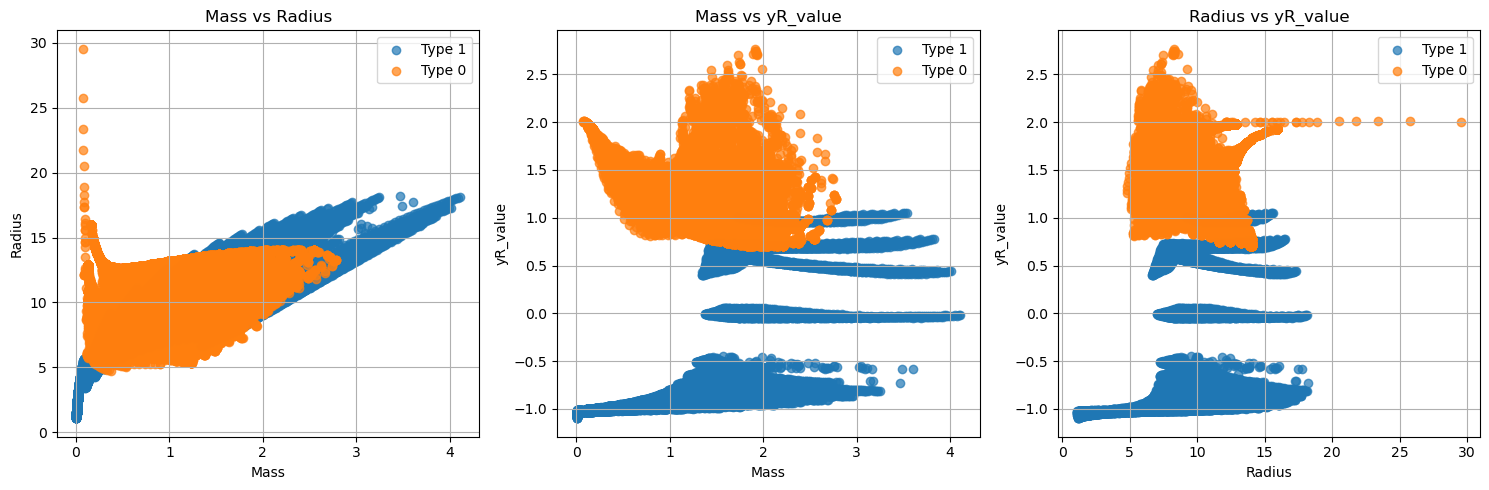

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

# Load the CSV
file_path = "custom_sample_mass_radius_y_ext_15.csv"
df = pd.read_csv(file_path)

# Select features and target
features = [col for col in df.columns if col != "Type"]
target = "Type"

# Create all pairwise feature plots
pairs = list(combinations(features, 2))
plt.figure(figsize=(5 * len(pairs), 5))

for i, (f1, f2) in enumerate(pairs, 1):
    plt.subplot(1, len(pairs), i)
    for t in df[target].unique():
        subset = df[df[target] == t]
        plt.scatter(subset[f1], subset[f2], label=f"Type {t}", alpha=0.7)
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.legend()
    plt.title(f"{f1} vs {f2}")
    plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd
import numpy as np
import os
import glob

def custom_sample_with_slope(df, samples, slope_threshold=0.01, apply_slope_limit=False, min_consecutive=3):
    df.columns = df.columns.str.strip().str.capitalize()
    if not all(col in df.columns for col in ["Mass", "Radius", "K2"]):
        raise ValueError("Missing one of required columns: Mass, Radius, K2")
    
    df_sorted = df.sort_values("Mass").reset_index(drop=True)
    
    if apply_slope_limit:
        slopes = np.gradient(df_sorted["Mass"], df_sorted["Radius"])
        
        # Find consecutive flat slope indices
        flat = np.abs(slopes) > slope_threshold
        count = 0
        cutoff_idx = None
        for i, f in enumerate(flat):
            if f:
                count += 1
                if count >= min_consecutive:
                    cutoff_idx = i - min_consecutive + 1
                    break
            else:
                count = 0
        
        # If found, keep only before the plateau starts (drop low-mass flat region)
        if cutoff_idx is not None:
            df_sorted = df_sorted.iloc[cutoff_idx:].reset_index(drop=True)

    # Sampling evenly in mass
    min_mass = df_sorted["Mass"].min()
    max_mass = df_sorted["Mass"].max()
    target_masses = np.linspace(min_mass, max_mass, samples)
    
    chosen_rows = pd.DataFrame()
    for tm in target_masses:
        idx = (df_sorted["Mass"] - tm).abs().idxmin()
        chosen_rows = pd.concat([chosen_rows, df_sorted.loc[[idx]]])
    
    # Always include max mass point
    max_mass_row = df_sorted.loc[df_sorted["Mass"].idxmax()]
    if not (chosen_rows["Mass"] == max_mass_row["Mass"]).any():
        chosen_rows = pd.concat([chosen_rows, pd.DataFrame([max_mass_row])])
    
    # Ensure at least one smaller mass + smaller radius
    smaller_candidates = df_sorted[
        (abs(df_sorted["Mass"] - max_mass_row["Mass"]) < 1e-1) &
        (df_sorted["Radius"] < max_mass_row["Radius"])
    ]
    if not smaller_candidates.empty:
        chosen_rows = pd.concat([chosen_rows, smaller_candidates.head(1)])
    
    return chosen_rows.drop_duplicates().reset_index(drop=True)

# File patterns
file_patterns = [
    r"C:\Users\vasil\Desktop\TOV DATA\GIT_TOV_EQUATION\Quark Stars\TOV_results_Qark_Stars_tidal\TOV_results_CFL*.csv",
    r"C:\Users\vasil\Desktop\TOV DATA\GIT_TOV_EQUATION\polytropic_stars\polytropic_main\TOV_results_tidal_HLPS2\EOS_*.csv",
    r"C:\Users\vasil\Desktop\TOV DATA\GIT_TOV_EQUATION\polytropic_stars\polytropic_main\TOV_results_tidal_HLPS3\EOS_*.csv"
]

sampled_data = []

for pattern in file_patterns:
    files = glob.glob(pattern)
    print(f"📁 Found {len(files)} files for pattern: {pattern}")
    for file in files:
        df = pd.read_csv(file)
        if 'CFL' in file:
            sample = custom_sample_with_slope(df, samples=15, slope_threshold=1.5*1e-2, apply_slope_limit=False)
        else:
            sample = custom_sample_with_slope(df, samples=15, slope_threshold=1.5*1e-2, apply_slope_limit=True)
        sampled_data.append(sample)

# Combine all samples
final_sample = pd.concat(sampled_data, ignore_index=True)

# Keep only Mass, Radius, K2
final_sample = final_sample[["Mass", "Radius", "K2", "Type"]]

# Save
output_path = "custom_sample_mass_radius_k2_15.csv"
final_sample.to_csv(output_path, index=False)

print(f"✅ Saved sampled data to {output_path}")
print(final_sample.head())


📁 Found 2029 files for pattern: C:\Users\vasil\Desktop\TOV DATA\GIT_TOV_EQUATION\Quark Stars\TOV_results_Qark_Stars_tidal\TOV_results_CFL*.csv
📁 Found 1024 files for pattern: C:\Users\vasil\Desktop\TOV DATA\GIT_TOV_EQUATION\polytropic_stars\polytropic_main\TOV_results_tidal_HLPS2\EOS_*.csv
📁 Found 1024 files for pattern: C:\Users\vasil\Desktop\TOV DATA\GIT_TOV_EQUATION\polytropic_stars\polytropic_main\TOV_results_tidal_HLPS3\EOS_*.csv
✅ Saved sampled data to custom_sample_mass_radius_k2_15.csv
       Mass  Radius        K2  Type
0  0.023955    2.99  0.724897     1
1  0.165144    5.65  0.629550     1
2  0.309391    6.93  0.568804     1
3  0.450308    7.80  0.512867     1
4  0.581916    8.45  0.471074     1


In [58]:
df = pd.read_csv("custom_sample_mass_radius_k2.csv")

print(len(df))  # Display the number of rows in the final sample

13285


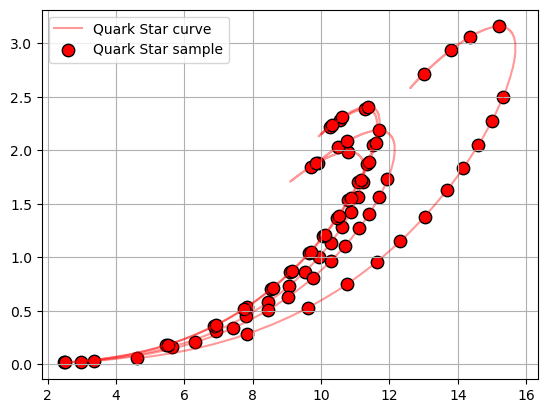

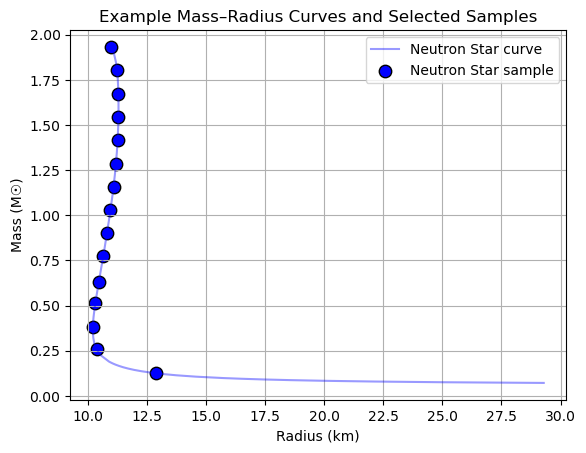

C:\Users\vasil\AppData\Local\Temp\ipykernel_19156\1138201257.py:85: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


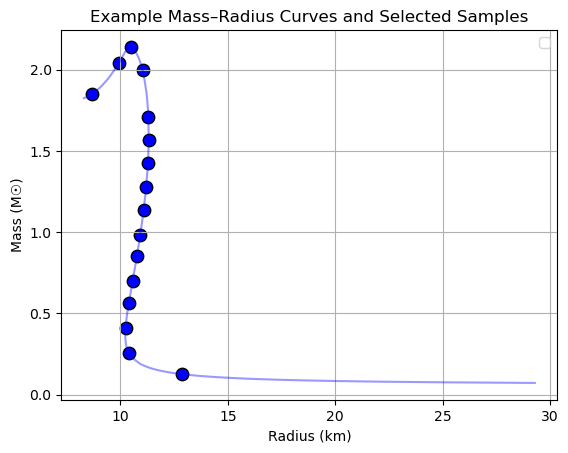

C:\Users\vasil\AppData\Local\Temp\ipykernel_19156\1138201257.py:85: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


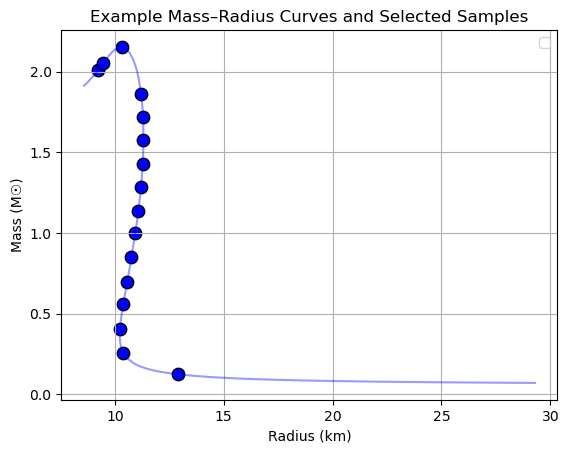

C:\Users\vasil\AppData\Local\Temp\ipykernel_19156\1138201257.py:85: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


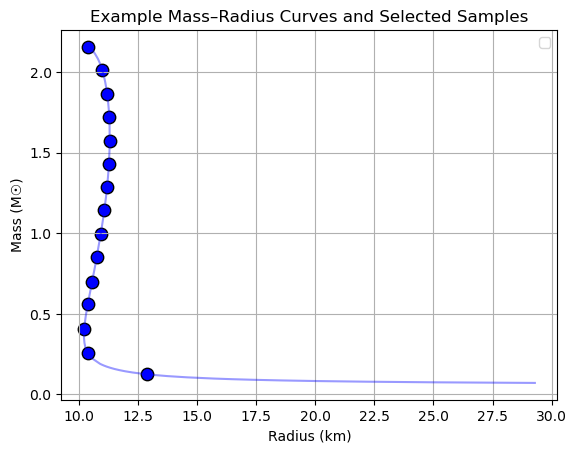

C:\Users\vasil\AppData\Local\Temp\ipykernel_19156\1138201257.py:85: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


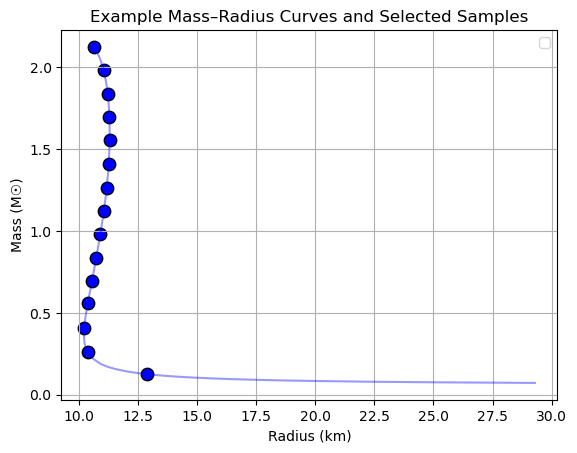

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

def custom_sample_with_slope(df, samples, slope_threshold=0.01, apply_slope_limit=False, min_consecutive=3):
    df.columns = df.columns.str.strip().str.capitalize()
    if not all(col in df.columns for col in ["Mass", "Radius", "K2"]):
        raise ValueError("Missing one of required columns: Mass, Radius, K2")
    
    df_sorted = df.sort_values("Mass").reset_index(drop=True)
    
    if apply_slope_limit:
        slopes = np.gradient(df_sorted["Mass"], df_sorted["Radius"])
        
        # Find consecutive flat slope indices
        flat = np.abs(slopes) > slope_threshold
        count = 0
        cutoff_idx = None
        for i, f in enumerate(flat):
            if f:
                count += 1
                if count >= min_consecutive:
                    cutoff_idx = i - min_consecutive + 1
                    break
            else:
                count = 0
        
        # If found, keep only before the plateau starts (drop low-mass flat region)
        if cutoff_idx is not None:
            df_sorted = df_sorted.iloc[cutoff_idx:].reset_index(drop=True)

    # Sampling evenly in mass
    min_mass = df_sorted["Mass"].min()
    max_mass = df_sorted["Mass"].max()
    target_masses = np.linspace(min_mass, max_mass, samples)
    
    chosen_rows = pd.DataFrame()
    for tm in target_masses:
        idx = (df_sorted["Mass"] - tm).abs().idxmin()
        chosen_rows = pd.concat([chosen_rows, df_sorted.loc[[idx]]])
    
    # Always include max mass point
    max_mass_row = df_sorted.loc[df_sorted["Mass"].idxmax()]
    if not (chosen_rows["Mass"] == max_mass_row["Mass"]).any():
        chosen_rows = pd.concat([chosen_rows, pd.DataFrame([max_mass_row])])
    
    # Ensure at least one smaller mass + smaller radius
    smaller_candidates = df_sorted[
        (abs(df_sorted["Mass"] - max_mass_row["Mass"]) < 1e-1) &
        (df_sorted["Radius"] < max_mass_row["Radius"])
    ]
    if not smaller_candidates.empty:
        chosen_rows = pd.concat([chosen_rows, smaller_candidates.head(1)])
    
    return chosen_rows.drop_duplicates().reset_index(drop=True)

# File patterns
quark_pattern = r"C:\Users\vasil\Desktop\TOV DATA\GIT_TOV_EQUATION\Quark Stars\TOV_results_Qark_Stars_tidal\TOV_results_CFL*.csv"
neutron_pattern = r"C:\Users\vasil\Desktop\TOV DATA\GIT_TOV_EQUATION\polytropic_stars\polytropic_main\TOV_results_tidal_HLPS2\EOS_*.csv"

# Pick first 2 files from each
quark_files = glob.glob(quark_pattern)[:5]
neutron_files = glob.glob(neutron_pattern)[:5]



for file in quark_files:
    df = pd.read_csv(file)
    plt.plot(df["Radius"], df["Mass"], alpha=0.4, color="red", label="Quark Star curve" if file == quark_files[0] else "")
    sample = custom_sample_with_slope(df, samples=15, apply_slope_limit=False)
    plt.scatter(sample["Radius"], sample["Mass"], edgecolor="black", color="red", s=80, label="Quark Star sample" if file == quark_files[0] else "")
plt.legend()
plt.grid(True)
plt.show()
for file in neutron_files:
    df = pd.read_csv(file)
    plt.plot(df["Radius"], df["Mass"], alpha=0.4, color="blue", label="Neutron Star curve" if file == neutron_files[0] else "")
    sample = custom_sample_with_slope(df, samples=15, slope_threshold=1.5*1e-2, apply_slope_limit=True)
    plt.scatter(sample["Radius"], sample["Mass"], edgecolor="black", color="blue", s=80, label="Neutron Star sample" if file == neutron_files[0] else "")
    plt.xlabel("Radius (km)")
    plt.ylabel("Mass (M☉)")
    plt.title("Example Mass–Radius Curves and Selected Samples")
    plt.legend()
    plt.grid(True)
    plt.show()


In [6]:
import pandas as pd
import numpy as np
import os
import glob

def custom_sample_with_slope(df, samples, slope_threshold=0.01, apply_slope_limit=False, min_consecutive=3):
    df.columns = df.columns.str.strip()
    if not all(col in df.columns for col in ["Mass", "Radius"]):
        raise ValueError("Missing one of required columns: Mass, Radius")
    
    df_sorted = df.sort_values("Mass").reset_index(drop=True)
    
    if apply_slope_limit:
        slopes = np.gradient(df_sorted["Mass"], df_sorted["Radius"])
        
        # Find consecutive flat slope indices
        flat = np.abs(slopes) > slope_threshold
        count = 0
        cutoff_idx = None
        for i, f in enumerate(flat):
            if f:
                count += 1
                if count >= min_consecutive:
                    cutoff_idx = i - min_consecutive + 1
                    break
            else:
                count = 0
        
        if cutoff_idx is not None:
            df_sorted = df_sorted.iloc[cutoff_idx:].reset_index(drop=True)

    # Sampling evenly in mass
    min_mass = df_sorted["Mass"].min()
    max_mass = df_sorted["Mass"].max()
    target_masses = np.linspace(min_mass, max_mass, samples)
    
    chosen_rows = pd.DataFrame()
    for tm in target_masses:
        idx = (df_sorted["Mass"] - tm).abs().idxmin()
        chosen_rows = pd.concat([chosen_rows, df_sorted.loc[[idx]]])
    
    max_mass_row = df_sorted.loc[df_sorted["Mass"].idxmax()]
    if not (chosen_rows["Mass"] == max_mass_row["Mass"]).any():
        chosen_rows = pd.concat([chosen_rows, pd.DataFrame([max_mass_row])])
    
    smaller_candidates = df_sorted[
        (abs(df_sorted["Mass"] - max_mass_row["Mass"]) < 1e-1) &
        (df_sorted["Radius"] < max_mass_row["Radius"])
    ]
    if not smaller_candidates.empty:
        chosen_rows = pd.concat([chosen_rows, smaller_candidates.head(1)])
    
    return chosen_rows.drop_duplicates().reset_index(drop=True)


# File patterns
file_patterns = [
    r"C:\Users\vasil\Desktop\TOV DATA\GIT_TOV_EQUATION\Quark Stars\TOV_results_Qark_Stars_tidal\TOV_results_CFL*.csv",
    r"C:\Users\vasil\Desktop\TOV DATA\GIT_TOV_EQUATION\polytropic_stars\polytropic_main\TOV_results_tidal_HLPS2\EOS_*.csv",
    r"C:\Users\vasil\Desktop\TOV DATA\GIT_TOV_EQUATION\polytropic_stars\polytropic_main\TOV_results_tidal_HLPS3\EOS_*.csv"
]

sampled_data = []

for pattern in file_patterns:
    files = glob.glob(pattern)
    print(f"📁 Found {len(files)} files for pattern: {pattern}")
    for file in files:
        df = pd.read_csv(file)
        # Determine star type
        if 'CFL' in file:  # Quark stars
            col_name = "yR"
            if col_name not in df.columns:
                raise ValueError(f"'{col_name}' column missing in file: {file}")
            sample = custom_sample_with_slope(df, samples=15, slope_threshold=1.5e-2, apply_slope_limit=False)
            sample["yR_value"] = sample[col_name]
        else:  # Neutron stars
            col_name = "yR"
            if col_name not in df.columns:
                raise ValueError(f"'{col_name}' column missing in file: {file}")
            sample = custom_sample_with_slope(df, samples=15, slope_threshold=1.5e-2, apply_slope_limit=True)
            sample["yR_value"] = sample[col_name]
        
        # Only keep common columns
        sample = sample[["Mass", "Radius", "yR_value", "Type"]]
        sampled_data.append(sample)

# Combine all samples
final_sample = pd.concat(sampled_data, ignore_index=True)

# Save
output_path = "custom_sample_mass_radius_y_15.csv"
final_sample.to_csv(output_path, index=False)

print(f"✅ Saved sampled data to {output_path}")
print(final_sample.head())


📁 Found 2029 files for pattern: C:\Users\vasil\Desktop\TOV DATA\GIT_TOV_EQUATION\Quark Stars\TOV_results_Qark_Stars_tidal\TOV_results_CFL*.csv
📁 Found 1024 files for pattern: C:\Users\vasil\Desktop\TOV DATA\GIT_TOV_EQUATION\polytropic_stars\polytropic_main\TOV_results_tidal_HLPS2\EOS_*.csv
📁 Found 1024 files for pattern: C:\Users\vasil\Desktop\TOV DATA\GIT_TOV_EQUATION\polytropic_stars\polytropic_main\TOV_results_tidal_HLPS3\EOS_*.csv
✅ Saved sampled data to custom_sample_mass_radius_y_15.csv
       Mass  Radius  yR_value  Type
0  0.023955    2.99  1.982919     1
1  0.165144    5.65  1.935017     1
2  0.309391    6.93  1.897617     1
3  0.450308    7.80  1.864465     1
4  0.581916    8.45  1.835048     1


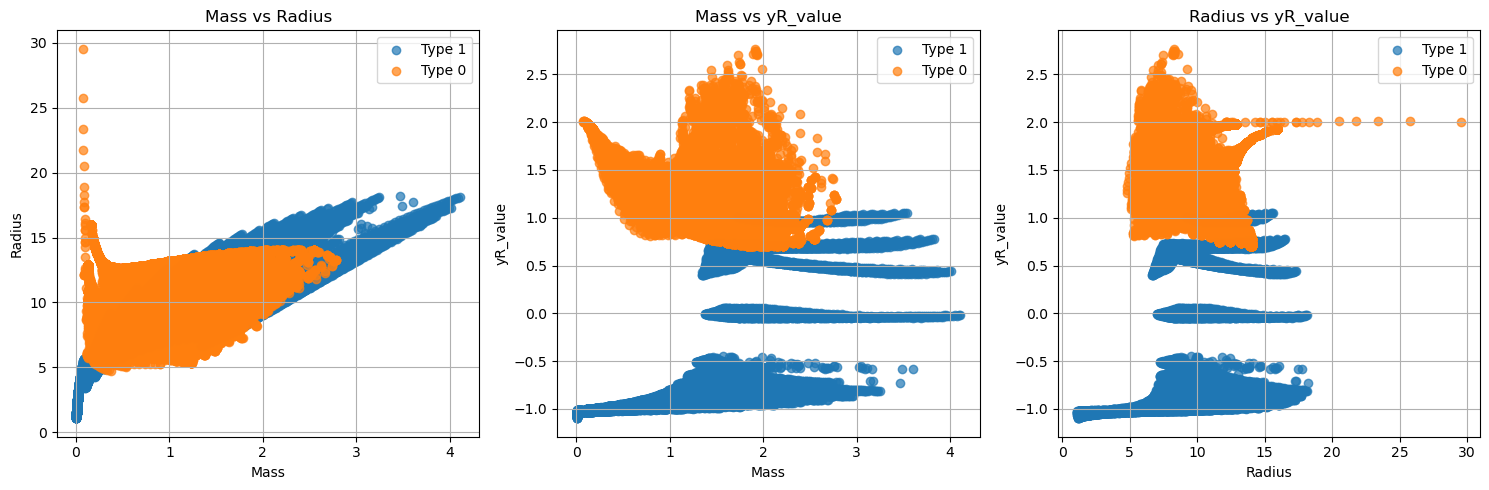

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

# Load the CSV
file_path = "custom_sample_mass_radius_y.csv"
df = pd.read_csv(file_path)

# Select features and target
features = [col for col in df.columns if col != "Type"]
target = "Type"

# Create all pairwise feature plots
pairs = list(combinations(features, 2))
plt.figure(figsize=(5 * len(pairs), 5))

for i, (f1, f2) in enumerate(pairs, 1):
    plt.subplot(1, len(pairs), i)
    for t in df[target].unique():
        subset = df[df[target] == t]
        plt.scatter(subset[f1], subset[f2], label=f"Type {t}", alpha=0.7)
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.legend()
    plt.title(f"{f1} vs {f2}")
    plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
import pandas as pd
import numpy as np
import os
import glob

def custom_sample_with_slope(df, samples, slope_threshold=0.01, apply_slope_limit=False, min_consecutive=3):
    df.columns = df.columns.str.strip()
    if not all(col in df.columns for col in ["Mass", "Radius"]):
        raise ValueError("Missing one of required columns: Mass, Radius")
    
    df_sorted = df.sort_values("Mass").reset_index(drop=True)
    
    if apply_slope_limit:
        slopes = np.gradient(df_sorted["Mass"], df_sorted["Radius"])
        
        # Find consecutive flat slope indices
        flat = np.abs(slopes) > slope_threshold
        count = 0
        cutoff_idx = None
        for i, f in enumerate(flat):
            if f:
                count += 1
                if count >= min_consecutive:
                    cutoff_idx = i - min_consecutive + 1
                    break
            else:
                count = 0
        
        if cutoff_idx is not None:
            df_sorted = df_sorted.iloc[cutoff_idx:].reset_index(drop=True)

    # Sampling evenly in mass
    min_mass = df_sorted["Mass"].min()
    max_mass = df_sorted["Mass"].max()
    target_masses = np.linspace(min_mass, max_mass, samples)
    
    chosen_rows = pd.DataFrame()
    for tm in target_masses:
        idx = (df_sorted["Mass"] - tm).abs().idxmin()
        chosen_rows = pd.concat([chosen_rows, df_sorted.loc[[idx]]])
    
    max_mass_row = df_sorted.loc[df_sorted["Mass"].idxmax()]
    if not (chosen_rows["Mass"] == max_mass_row["Mass"]).any():
        chosen_rows = pd.concat([chosen_rows, pd.DataFrame([max_mass_row])])
    
    smaller_candidates = df_sorted[
        (abs(df_sorted["Mass"] - max_mass_row["Mass"]) < 1e-1) &
        (df_sorted["Radius"] < max_mass_row["Radius"])
    ]
    if not smaller_candidates.empty:
        chosen_rows = pd.concat([chosen_rows, smaller_candidates.head(1)])
    
    return chosen_rows.drop_duplicates().reset_index(drop=True)


# File patterns
file_patterns = [
    r"C:\Users\vasil\Desktop\TOV DATA\GIT_TOV_EQUATION\Quark Stars\TOV_results_Qark_Stars_tidal\TOV_results_CFL*.csv",
    r"C:\Users\vasil\Desktop\TOV DATA\GIT_TOV_EQUATION\polytropic_stars\polytropic_main\TOV_results_tidal_HLPS2\EOS_*.csv",
    r"C:\Users\vasil\Desktop\TOV DATA\GIT_TOV_EQUATION\polytropic_stars\polytropic_main\TOV_results_tidal_HLPS3\EOS_*.csv"
]

sampled_data = []

for pattern in file_patterns:
    files = glob.glob(pattern)
    print(f"📁 Found {len(files)} files for pattern: {pattern}")
    for file in files:
        df = pd.read_csv(file)
        # Determine star type
        if 'CFL' in file:  # Quark stars
            col_name = "yR"
            if col_name not in df.columns:
                raise ValueError(f"'{col_name}' column missing in file: {file}")
            sample = custom_sample_with_slope(df, samples=15, slope_threshold=1.5e-2, apply_slope_limit=False)
            sample["yR_value"] = sample[col_name]
        else:  # Neutron stars
            col_name = "yR"
            if col_name not in df.columns:
                raise ValueError(f"'{col_name}' column missing in file: {file}")
            sample = custom_sample_with_slope(df, samples=15, slope_threshold=1.5e-2, apply_slope_limit=True)
            sample["yR_value"] = sample[col_name]
        
        # Only keep common columns
        sample = sample[["Mass", "Radius", "Pressure","yR_value", "Type"]]
        sampled_data.append(sample)

# Combine all samples
final_sample = pd.concat(sampled_data, ignore_index=True)

# Save
output_path = "custom_sample_mass_radius__pressure_y_15.csv"
final_sample.to_csv(output_path, index=False)

print(f"✅ Saved sampled data to {output_path}")
print(final_sample.head())


📁 Found 2029 files for pattern: C:\Users\vasil\Desktop\TOV DATA\GIT_TOV_EQUATION\Quark Stars\TOV_results_Qark_Stars_tidal\TOV_results_CFL*.csv
📁 Found 1024 files for pattern: C:\Users\vasil\Desktop\TOV DATA\GIT_TOV_EQUATION\polytropic_stars\polytropic_main\TOV_results_tidal_HLPS2\EOS_*.csv
📁 Found 1024 files for pattern: C:\Users\vasil\Desktop\TOV DATA\GIT_TOV_EQUATION\polytropic_stars\polytropic_main\TOV_results_tidal_HLPS3\EOS_*.csv
✅ Saved sampled data to custom_sample_mass_radius__pressure_y_15.csv
       Mass  Radius  Pressure  yR_value  Type
0  0.023955    2.99       1.5  1.982919     1
1  0.165144    5.65       6.0  1.935017     1
2  0.309391    6.93      10.0  1.897617     1
3  0.450308    7.80      14.0  1.864465     1
4  0.581916    8.45      18.0  1.835048     1
